### Feature Engineering
1. Create 2nd and 3rd order polynomial columns for hd
2. Combine 'cd' and 'multi' features. If 'cd' and 'multi' are both yes then 1, else 0
3. Bin 'ram' values into <=4, 8 and 16+ and check if it improves the model.
4. Create dummy variables for categorical columns

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns


In [2]:
computers = pd.read_csv('/Users/AnirbanGuha/Library/CloudStorage/OneDrive-Personal/Maven Analytics Courses/Data Science in Python - Regression/Course Materials/Data/Computers.csv')

In [3]:
computers.head()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
0,1499,25,80,4,14,no,no,yes,94,1
1,1795,33,85,2,14,no,no,yes,94,1
2,1595,25,170,4,15,no,no,yes,94,1
3,1849,25,170,8,14,no,no,no,94,1
4,3295,33,340,16,14,no,no,yes,94,1


In [5]:
computers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6259 entries, 0 to 6258
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   price    6259 non-null   int64 
 1   speed    6259 non-null   int64 
 2   hd       6259 non-null   int64 
 3   ram      6259 non-null   int64 
 4   screen   6259 non-null   int64 
 5   cd       6259 non-null   object
 6   multi    6259 non-null   object
 7   premium  6259 non-null   object
 8   ads      6259 non-null   int64 
 9   trend    6259 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 489.1+ KB


In [20]:
target = "price"
features = [
    "speed",
    "hd",
    "ram",
    "screen",
    "ads",
    "trend"
]


In [141]:
computers_eng = (
    pd.get_dummies(    
        computers.assign(
            hd2 = computers['hd'] ** 2
            ,hd3 = computers['hd'] ** 3
            ,ports = np.where((computers['cd'] == 'yes') & (computers['multi'] == 'yes'),\
                             1,0)
            ,ram_categories = pd.cut(computers['ram'],bins=[0, 4, 8, 16], labels=['<=4','8','16+'])
        )\
            .drop(columns = ['ram','cd','multi'])
    ,drop_first=True,dtype="int"
    )
)

In [142]:
# X = sm.add_constant(computers[features])
X = sm.add_constant(computers_eng.drop("price", axis=1))
y = np.log(computers[target])

In [143]:
#Split the feature dataset into training and test
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=1000)

In [144]:
#Build the model based on training dataset
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1414.
Date:                Fri, 11 Jul 2025   Prob (F-statistic):               0.00
Time:                        22:04:10   Log-Likelihood:                 3223.9
No. Observations:                5007   AIC:                            -6424.
Df Residuals:                    4995   BIC:                            -6346.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.8169      0.032    215.865      0.000       6.755       6.879
speed                  0.0038   9.77e-05     38.401      0.000       0.004       0.004
hd                     0.0012    5.6e-05     21.027      0.000       0.001       0.001
screen                 0.0543      0.002     26.110      0.000       0.050       0.058
ads                    0.0003   2.67e-05      9.737      0.000       0.000       0.000
trend                 -0.0260      0.000    -79.667      0.000      -0.027      -0.025
hd2                -4.903e-07   7.59e-08     -6.461      0.000   -6.39e-07   -3.42e-07
hd3                 1.028e-10   3.09e-11      3.326      0.001    4.22e-11    1.63e-10
ports                  0.0695      0.005     13.069      0.000       0.059       0.080
premium_yes           -0.2383      0.006    -37.190      0.000      -0.251      -0.226
ram_categories_8       0.0381      0.005      7.214      0.000       0.028       0.048
ram_categories_16+     0.1443      0.007     21.028      0.000       0.131       0.158
==============================================================================
Omnibus:                       13.053   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.840
Skew:                          -0.036   Prob(JB):                     0.000363
Kurtosis:                       3.266   Cond. No.                     7.97e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.97e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [145]:
#Cross-validate the model splitting the training dataset into K-Folds
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=True,random_state=1023)

In [146]:
#Create empty lists to store the model scores
cv_r2 = []
cv_mae = []

In [147]:
from sklearn.metrics import r2_score as r2, \
        mean_absolute_error as mae, mean_squared_error as mse

#Lopp through each fold in X and y
for train_ind, val_ind in kf.split(X, y):
    #Subset data into CV_folds
    X_train, y_train  = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]

    #Train the model in C_train, y_train dataset
    model = sm.OLS(y_train, X_train).fit()
    predictions = model.predict(X_val)

    #Store the scores in the appropriate lists
    cv_mae.append(mae(y_val, predictions))
    cv_r2.append(r2(y_val, predictions))

In [148]:
print('All validations MAEs:', [round(x,3) for x in cv_mae])
print(f'Cross Validation MAEs: {round(np.mean(cv_mae),3)} +- {round(np.std(cv_mae),3)}')

All validations MAEs: [0.101, 0.098, 0.1, 0.1, 0.1]
Cross Validation MAEs: 0.1 +- 0.001


In [149]:
print('All validations R2s:', [round(x,3) for x in cv_r2])
print(f'Cross Validation R2s: {round(np.mean(cv_r2),3)} +- {round(np.std(cv_r2),3)}') 

All validations R2s: [0.766, 0.767, 0.743, 0.747, 0.752]
Cross Validation R2s: 0.755 +- 0.01


In [150]:
# ### Residual plotter helper function

# def residual_analysis_plots(model):
    
#     import scipy.stats as stats
#     import matplotlib.pyplot as plt
    
#     predictions = model.predict()
#     residuals = model.resid
    
#     fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
#     sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=.3)
#     ax[0].set_title("Residual Plot")
#     ax[0].set_xlabel("Prediction")
#     ax[0].set_ylabel("Residuals")
    
#     stats.probplot(residuals, dist="norm", plot=ax[1])
#     ax[1].set_title("Normal Q-Q Plot")   

In [177]:
from draw_residual_analysis import residual_analysis_plots
import importlib

importlib.reload(draw_residual_analysis);

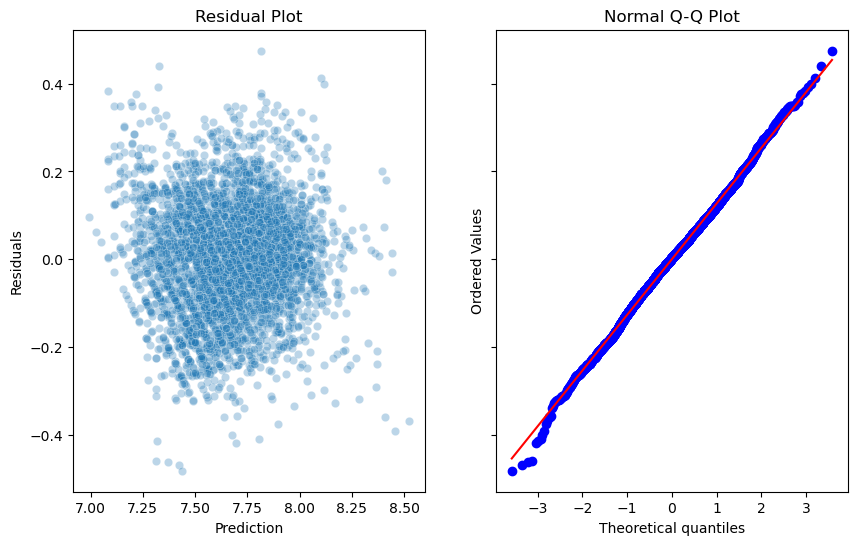

In [178]:
residual_analysis_plots(model)

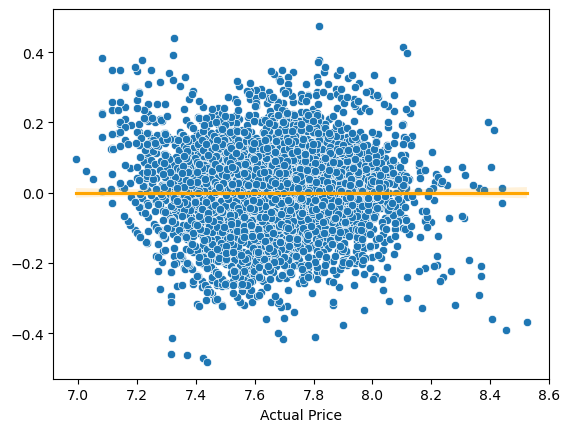

In [179]:
import matplotlib.pyplot as plt

sns.scatterplot(x=model.predict(), y=model.resid);
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

sns.regplot(x=model.predict(), y=model.resid, color='orange',scatter=False);